# 훈련된 CNN 모델의 각 층의 활성화 정도를 시각화하기
## 1. 기존 모델 불러오기
- 오랫동안 딥 러닝 알고리즘으로 만들어진 문제 해결 방식은 사람이 직접적으로 읽거나 보고 이해하는 것이 불가능하다고 여겨져 왔다. 하지만 컴퓨터 비전 문제를 해결하기 위한 CNN 모델을 훈련시켜 얻은 알고리즘은 시각 데이터를 기반으로 하고 있기 때문에 다양한 관점에서 시각화가 가능하다.
- 기존에 VGG16 모델을 미세조정하고 훈련 데이터를 증식하여 훈련했던 강아지 고양이 분류기 모델을 불러와 각 층이 어떤 의미를 가지고 있는지 시각화한다.

In [1]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 128)     

- 테스트 데이터 중 하나를 선택하여 이 데이터가 모델을 통과하는 과정에서 어떻게 작동하는지 살펴보자.
- 모델의 입력 사이즈에 맞게 형식과 차원을 조정해주고 값을 조정한다.

In [2]:
img_path = '../datasets/small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(150, 150, 3)
(1, 150, 150, 3)


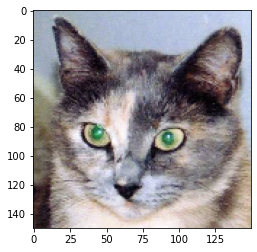

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

## 2. 다중 출력 모델 구성을 통한 각 층의 활성화 시각화
- 상위 8개의 합성곱 층과 풀링 층들의 출력들을 이용하여 입력 이미지를 바탕으로 각 층의 활성화 값을 출력하는 다중 출력 모델을 만든다.
- 이 모델은 하나의 입력 데이터에 대하여 각 층당 1개씩 8개의 활성화 출력을 가진다.

In [4]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

(1, 148, 148, 32)


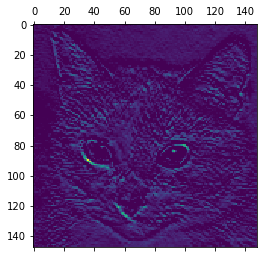

In [5]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0,:,:,19], cmap='viridis')

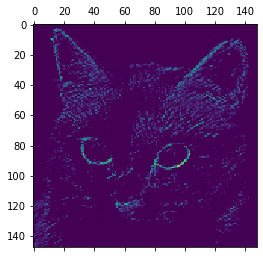

In [6]:
plt.matshow(first_layer_activation[0,:,:,15], cmap='viridis')

- 첫 번째 합성곱 층의 활성화 값의 형태는 (148, 148, 32) 인데, 원본 이미지 위의 필터가 스트라이드 되며 폭과 높이가 148로 줄어들고, 32개의 특성을 가진다는 것을 뜻한다.
- 이 층의 32개의 특성 중 19번째와 15번째 특성의 활성화 정도를 살펴보니 특정 패턴이나 질감을 활성화시키긴 하지만 원본 이미지의 데이터가 거의 그대로 보존되어 있다.
- 각각의 층의 필터들이 활성화되는 방식을 한번에 표시하여 각각의 층이 어떠한 방식으로 데이터를 해석하는지 살펴본다.

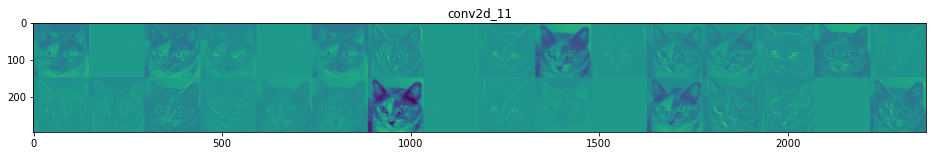

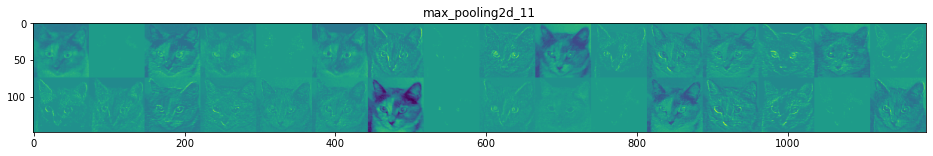

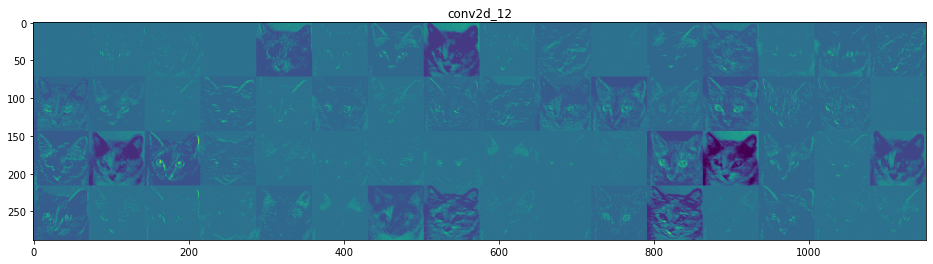

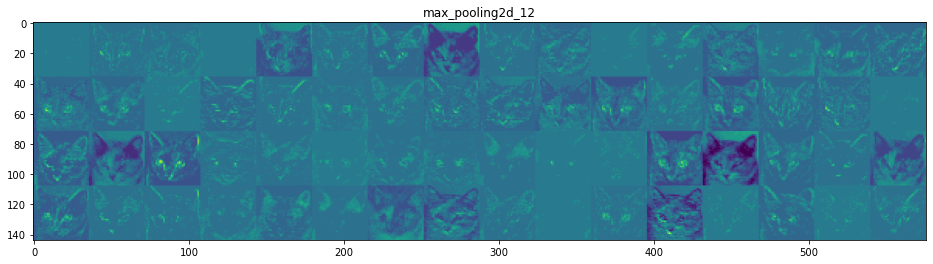

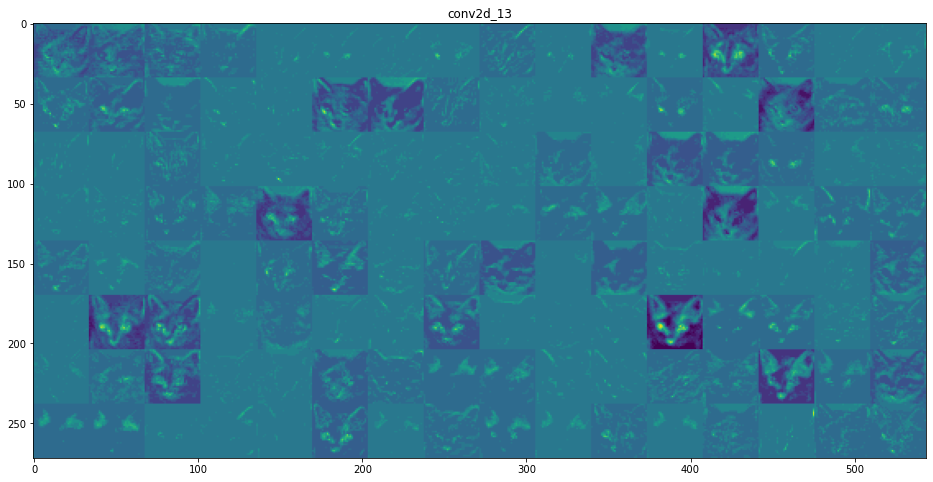

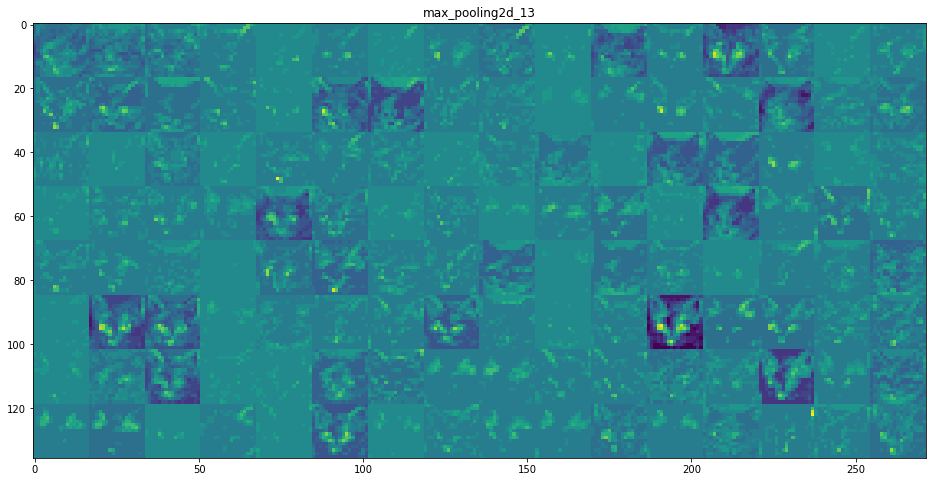

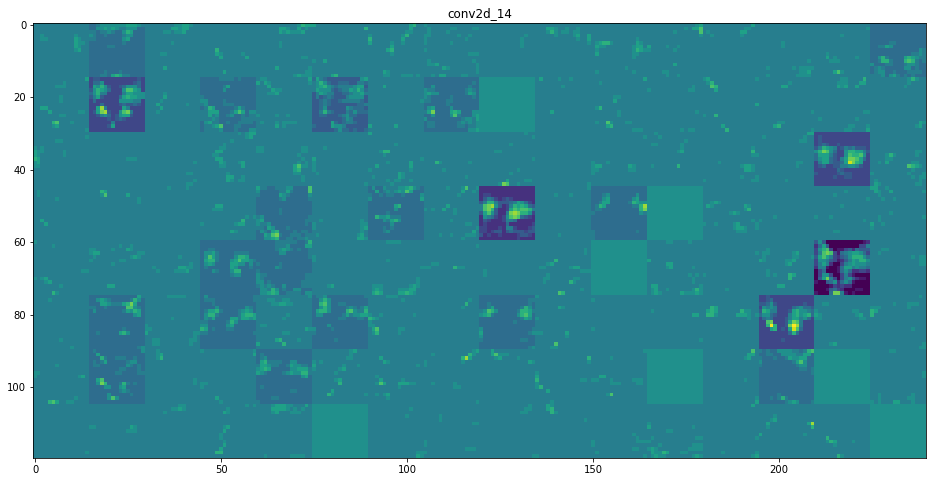

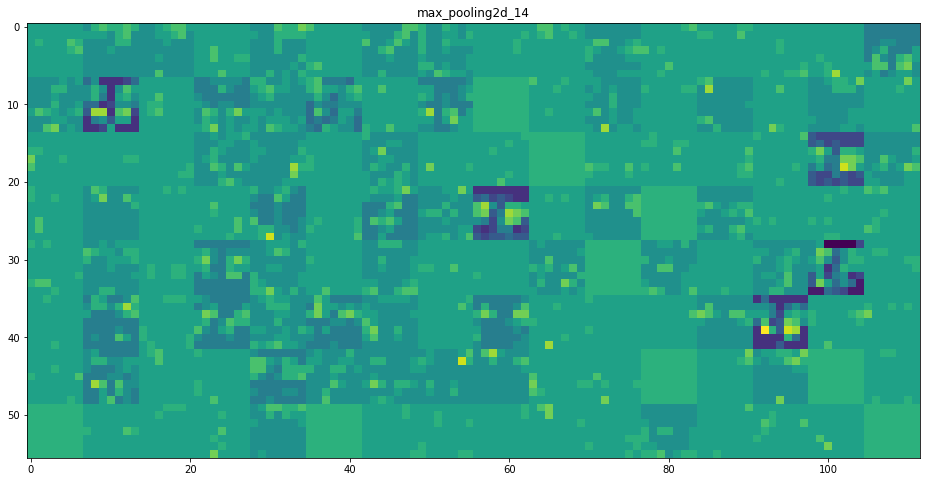

In [7]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image -= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size:(row+1)*size] = channel_image
    
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

- 각 층의 활성화 정도를 시각화한 결과, 하위 층에서는 더 일반적이고 지역적인 패턴이나 색상, 질감 등을 감지하는 필터들이 있으며, 상위 층으로 갈 수록 고양이의 눈, 귀, 코와 같은 더 추상적이고 고차원적인 개념을 확인하는 필터가 존재한다는 것을 확인할 수 있다.
- 또한 최대 풀링 층을 통과하면서 윈도우 사이즈가 커지는 것의 효과로 필터링이 다소 단순화되고 추상화되는 것을 볼 수 있었다.
- 인간이 어떤 물체를 시각적으로 관찰하고 인식할 때 추상적인 구조와 고차원적인 개념으로 인식하고 기억하지만 세부적인 질감이나 자세한 형태들을 완벽하게 기억하지 못하는 것 처럼, 상위 층과 하위 층에서 사용되는 필터의 인식 범위가 다르기 때문에 순차적으로 데이터를 분석하여 문제 해결에 알맞는 결론을 추론할 수 있다.